In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
from pprint import pprint
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 6

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device:  mps


100%|██████████| 6/6 [00:00<00:00, 6016.21it/s]


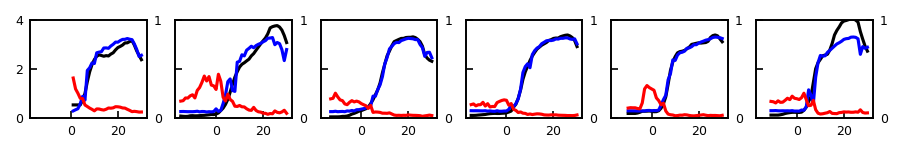

In [8]:
from morphogenesis.flow_translation.convnext_models import MaskedVAE
from morphogenesis.dataset import *
from morphogenesis.plot_utils import *

def residual(u, v):
    '''
    We assume u is the INPUT and v is the TARGET
    Using residual metric from Sebastian's eLife paper to track how flow configuration is predicted
    '''
    umag = np.linalg.norm(u, axis=-3)
    vmag = np.linalg.norm(v, axis=-3)

    uavg = np.sqrt(np.mean(umag**2, axis=(-2,-1), keepdims=True))
    vavg = np.sqrt(np.mean(vmag**2, axis=(-2,-1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    denom = 2 * vavg**2 * uavg**2
    denom[denom == 0] += 1
    res /= denom
    return res


model = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('tb_logs/MaskedVAE_sqh_beta=0.0001_split=embryo', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.eval()
model.to(device)

#Base datasets
sqh = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D',
    transform=Reshape2DField(), drop_time=True)
sqh_vel = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D',
    transform=Reshape2DField(), drop_time=True)

dataset = JointDataset(
    datasets=[
        ('sqh', sqh),
        ('vel', sqh_vel),
    ],
    live_key='vel',
)

df = dataset.df.copy()
df = df[df.merged_index >= 0]
embryos = df.embryoID.unique()
fig, ax = plt.subplots(1, len(embryos), dpi=150, 
                       sharex=True, sharey=True, figsize=(len(embryos), 1))

for i, eId in enumerate(embryos):
    eIdx = df.loc[df.embryoID == eId, 'eIdx'].values
    m = dataset.values[eId]['sqh'][eIdx]
    v0 = dataset.values[eId]['vel'][eIdx]
    t = df.loc[dataset.df.embryoID == eId, 'time'].values
    m = torch.FloatTensor(m).to(device).reshape([-1, 4, 236, 200])
    v1, _ = model(m)
    v1 = v1.detach().cpu().numpy()

    v_nrm = np.linalg.norm(v0, axis=1).mean(axis=(1,2))
    ax[i].plot(t, np.linalg.norm(v0, axis=1).mean(axis=(1,2)), color='black')
    ax[i].plot(t, np.linalg.norm(v1, axis=1).mean(axis=(1,2)), color='blue')
    
    ax2 = ax[i].twinx()
    ax2.plot(t, residual(v0, v1).mean(axis=(1,2)), color='red')
    ax2.set_ylim([0, 1])
    ax2.set_yticks([0, 1])

ax[0].set_ylim([0, 4])

plt.tight_layout()